<a href="https://colab.research.google.com/github/LeonardoGoncRibeiro/06_MachineLearning/blob/main/02_Advanced/05_06_NLP_SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing: Sentiment analysis, part 1

In this course, we will start working with natural language processing, in particular sentiment analysis. We will see how to perform automatized sentiment analyses, and how to build an architecture for that end. Also, we will see how to visualize the results for a sentiment analysis. In the end, we will use one of the most powerful Python libraries for NLP: NLTK.

In this course, we will use the following packages:

In [1]:
!pip install wordcloud --quiet

In [67]:
!pip install unidecode --quiet

     |████████████████████████████████| 235 kB 5.4 MB/s 


In [107]:
import pandas as pd
import numpy as np

import nltk
from string import punctuation
import unidecode

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

Also, we will try to perform sentiment analysis over the following dataset:

In [3]:
df = pd.read_csv("imdb-reviews-pt-br.csv", engine="python", nrows = 25000)

In [4]:
df.head( )

,id,text_en,text_pt,sentiment
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg


In this data set, we have an id, the english text, the portuguese text, and the sentiment.

# Machine Learning for text classification

Sentiment analysis is based on the use of usual machine learning techniques to classify text. Usually, there are three labels: -1 (bad), 0 (neutral), and 1 (good). Thus, let's try use a Logistic Regression to perform our sentiment analysis:

In [5]:
X = df.text_pt
y = df.sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y)

Note that, here, we are trying to understand what will be the sentiment of our text, based on the portuguese text.

In [6]:
model_logreg = LogisticRegression( )
model_logreg.fit(X_train, y_train)
acc = model_logreg.score(X_test, y_test)

ValueError: ignored

This actually did not work. This occurs because our model can not use text data as the explicative feature. Thus, we need to perform a transformation in our dataset that allows us to fit our model and to perform our prediction. Before going any further, let's understand a little more about out data.



## Understanding our data

First, let's see which sentiments do we have:

In [24]:
df.sentiment.value_counts( )

neg    12647
pos    12353
Name: sentiment, dtype: int64

So, we only have negative and positive sentiments. Also, the proportion is almost the same. Usually, when we have a negative sentiment, we use the label 0, and, when we have a positive sentiment, we use the label 1. Let's do this:

In [25]:
df['sentiment'] = df.sentiment.apply(lambda x : 1 if (x == 'pos') else 0)

Nice!

# Natural Language Processing

Natural Language Processing (NLP) studies how the computer can understand human language. An example for NLP is sentiment analysis, where the computer will be able to understand the sentiment that a person is passing after writing something about a movie.

In NLP, the dataset is also known as corpus. For instance, let's say that we have a corpus with two texts:

*   The movie is very good.
*   The movie is very bad.

Note that, here, "The movie is very" should not change the sentiment in our text, as they are present in movie texts. "Good" and "Bad", however, are very important for our analyses. To understand which words are in the text, an idea is to use a dummy encoder, in the representation known as Bad of Words.

https://en.wikipedia.org/wiki/Bag-of-words_model

Now, let's try to make a bag of words with a simple example:



In [26]:
text = ['The movie is very good', 'The movie is very bad']

vectorize = CountVectorizer( )
bag_of_words = vectorize.fit_transform(text)

In [27]:
bag_of_words

<2x6 sparse matrix of type '<class 'numpy.int64'>'
	with 10 stored elements in Compressed Sparse Row format>

So, we have a 2x6 sparse matrix. Let's try to store it into a sparse dataframe:

In [28]:
bag_of_words_df = pd.DataFrame.sparse.from_spmatrix(bag_of_words, columns = vectorize.get_feature_names_out( ))

In [29]:
bag_of_words_df

,bad,good,is,movie,the,very
0,0,1,1,1,1,1
1,1,0,1,1,1,1


Nice! We have used a dummy encoder to turn our text data into a binary data. Finally, let's get the bag of words for our example:

In [30]:
pt_bow = vectorize.fit_transform(df.text_pt)

Let's check the size of this sparse matrix:

In [31]:
pt_bow.shape

(25000, 94458)

Note that, here, we have 25000 entries, and 94458 features. This occurs because, here, we have 94458 different words. However, note that most of these words appear very few times, and hardly should influence our final prediction. Thus, let's reduce the number of features:

In [32]:
vectorize = CountVectorizer(max_features = 200)
pt_bow = vectorize.fit_transform(df.text_pt)
pt_bow.shape

(25000, 200)

Now, we only have 100 features. Now, let's make our classification:

In [33]:
SEED = 42
np.random.seed(42)

X = pt_bow
y = df.sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y)

model_logreg = LogisticRegression( )
model_logreg.fit(X_train, y_train)
acc = model_logreg.score(X_test, y_test)*100

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Nice! Now, we were able to run our model. However, our model had some issue converging to a good result. Let's check our accuracy:

In [34]:
print("Accuracy: {:.2f}%".format(acc))

Accuracy: 76.53%


Nice! Our first model was able to get an accuracy of 72.45%. That is a good start, as we were able to make the right guess in more than half of our recommendations.

Before going any further, we will repeat this process a lot. Thus, let's build a function that will receive a text, get the bag of words, and perform the classification:

In [35]:
def classify_text(text, text_col, class_col, vectorizer, model, seed = 42):
  np.random.seed(seed)

  bag_of_words = vectorizer.fit_transform(text[text_col])

  X = bag_of_words
  y = text[class_col]

  X_train, X_test, y_train, y_test = train_test_split(X, y)

  model.fit(X_train, y_train)
  
  return model.score(X_test, y_test)*100

Now, let's test it:

In [36]:
vec   = CountVectorizer(max_features = 200)
model = LogisticRegression( )

acc = classify_text(df, 'text_pt', 'sentiment', vec, model)

print("Accuracy: {:.2f}%".format(acc))

Accuracy: 76.53%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Nice! We got the same result.

## How can we improve our representation?

So, to improve our accuracy, we can try to use better models, or improve our data representation. First, let's see which features are we considering in our vectorizer:

In [37]:
vectorize.get_feature_names_out( )

array(['10', 'acho', 'agora', 'ainda', 'algo', 'algum', 'alguma',
       'algumas', 'alguns', 'alguém', 'além', 'anos', 'antes', 'ao',
       'apenas', 'aqui', 'as', 'assim', 'assistir', 'atores', 'atuação',
       'até', 'ação', 'bastante', 'bem', 'boa', 'bom', 'cada', 'cara',
       'cena', 'cenas', 'cinema', 'claro', 'coisa', 'coisas', 'com',
       'como', 'comédia', 'da', 'das', 'de', 'depois', 'deste', 'deve',
       'diretor', 'disso', 'dizer', 'do', 'dois', 'dos', 'durante', 'ela',
       'ele', 'elenco', 'eles', 'em', 'embora', 'engraçado', 'enquanto',
       'enredo', 'entanto', 'entre', 'então', 'era', 'eram', 'essa',
       'esse', 'esta', 'estava', 'este', 'estou', 'está', 'estão', 'eu',
       'faz', 'fazer', 'feito', 'fez', 'filme', 'filmes', 'final', 'foi',
       'fora', 'foram', 'forma', 'grande', 'história', 'homem', 'há',
       'isso', 'já', 'lo', 'lugar', 'mais', 'mal', 'maneira', 'mas', 'me',
       'melhor', 'melhores', 'menos', 'mesmo', 'meu', 'mim', 'minha',
 

To improve our visualization, we can make a word cloud:

In [38]:
all_words = ' '.join([phrases for phrases in df.text_pt])
word_cloud = WordCloud(width = 800, height = 500, max_font_size = 110, collocations = False).generate(all_words)

([], <a list of 0 Text major ticklabel objects>)

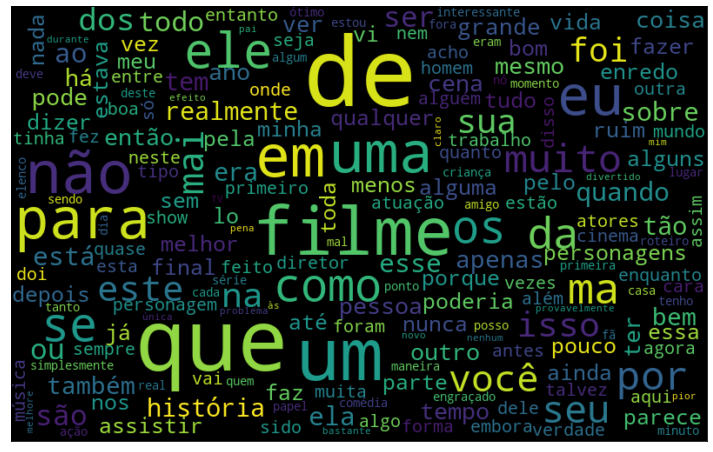

In [39]:
plt.figure(figsize = (16, 8))
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.xticks([])
plt.yticks([])

Note that, actually, these features are mostly words that do not say anything about our text. Most of them are prepositions or pronoums, that are present a lot in our text, but really can't help us to perform our classification.

Before going any further, let's try to plot two different word clouds: one for negative sentiments, and other for positive sentiments. This may give us a better sense of which words should be in our corpus.

First, for the negative sentiments:

([], <a list of 0 Text major ticklabel objects>)

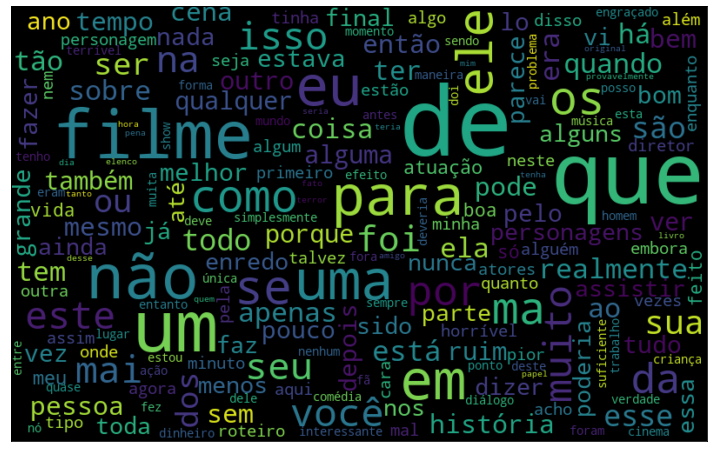

In [40]:
all_words = ' '.join([phrases for phrases in df.query("sentiment == 0").text_pt])
word_cloud = WordCloud(width = 800, height = 500, max_font_size = 110, collocations = False).generate(all_words)

plt.figure(figsize = (16, 8))
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.xticks([])
plt.yticks([])

And now, for the positive sentiments:

([], <a list of 0 Text major ticklabel objects>)

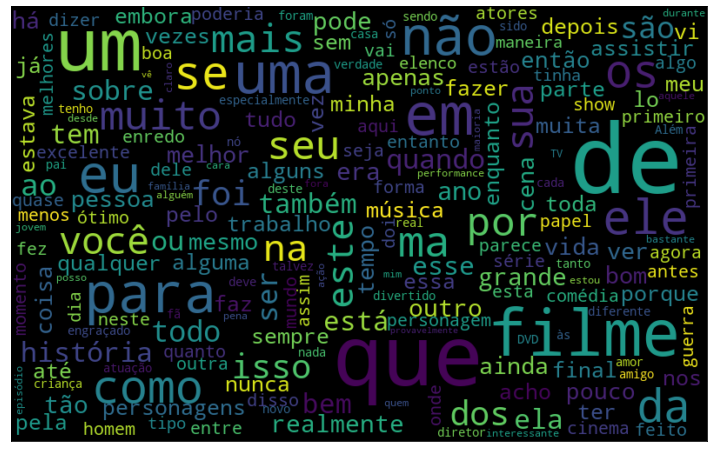

In [41]:
all_words = ' '.join([phrases for phrases in df.query("sentiment == 1").text_pt])
word_cloud = WordCloud(width = 800, height = 500, max_font_size = 110, collocations = False).generate(all_words)

plt.figure(figsize = (16, 8))
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.xticks([])
plt.yticks([])

Note that, actually, those word clouds are very similar: again, we see a lot of prepositions and pronoums. 

What can we do to improve our representation?

# Using NLTK

NLTK is one of the most popular packages for NLP using Python. To start things out, we will use NLTK to get the frequency of each word for our example. First, let's tokenize our text:



In [42]:
text

['The movie is very good', 'The movie is very bad']

In [43]:
token_space = nltk.tokenize.WhitespaceTokenizer( )

all_tokens = []

for t in text:
  token = token_space.tokenize(t)
  all_tokens = [*all_tokens, *token]

all_tokens

['The', 'movie', 'is', 'very', 'good', 'The', 'movie', 'is', 'very', 'bad']

Nice! Here, we are creating tokens for each word, checking if they are separated by a whitespace (' '). Now, to get the frequency of our tokens:

In [44]:
freq = nltk.FreqDist(all_tokens)
freq

FreqDist({'The': 2, 'bad': 1, 'good': 1, 'is': 2, 'movie': 2, 'very': 2})

Ok. Now, let's do the same thing for our real text:

In [45]:
all_tokens = token_space.tokenize(all_words)
freq = nltk.FreqDist(all_tokens)

To better visualize our frequencies, let's create a DataFrame:

In [46]:
freq_df = pd.DataFrame({"Word" : list(freq.keys( )), "Count" : list(freq.values( ))})

freq_df.head( )

,Word,Count
0,Eu,12480
1,fui,329
2,e,79964
3,vi,2526
4,este,8107


Nice. Finally, we can sort our values by their count:

In [47]:
freq_df.sort_values('Count', ascending = False).head(20)

,Word,Count
10,de,102553
2,e,79964
18,que,77147
37,o,60194
52,um,53335
70,a,52676
54,é,48395
21,em,34341
152,uma,32409
131,para,30707


We can also make a plot for our frequencies:

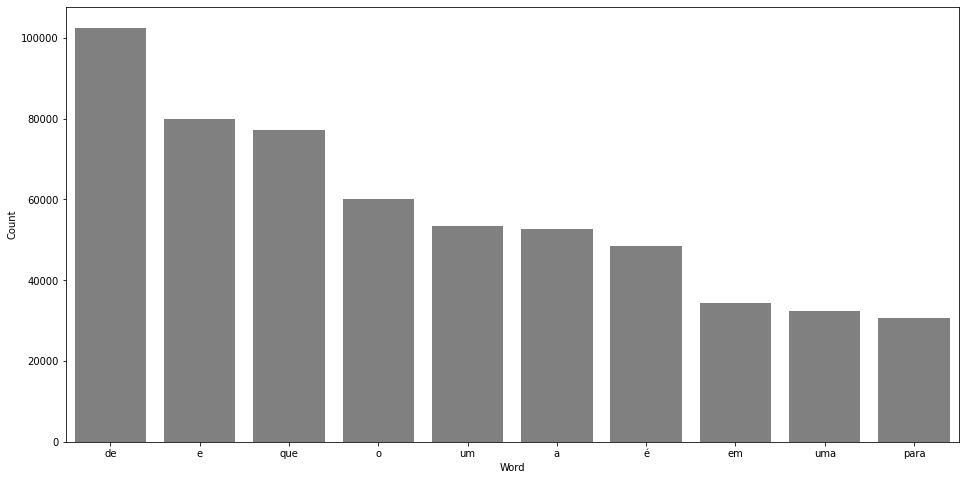

In [48]:
highest_freq_10 = freq_df.sort_values('Count', ascending = False).head(10)

plt.figure(figsize = (16, 8))
ax = sns.barplot(x = "Word", y = "Count", data = highest_freq_10, color = 'gray')

Ok. Indeed, we see that the most frequent words in our corpus actually don't say anything about the sentiment in our text. 

## Treating our data

Finally, let's exclude those words that have no meaning for us. These words are called stopwords. We can simply import them from nltk:

In [49]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [50]:
stopwords_pt = nltk.corpus.stopwords.words("portuguese")

Now, let's exclude those words from our data. First, we will create a function to eliminate the stopwords from one entry:

In [51]:
def EliminateStopwords(opinion):  
  new_phrase = list()
  words_text = token_space.tokenize(opinion)
  for word in words_text:
    if word not in stopwords_pt:
      new_phrase.append(word)
  
  return ' '.join(new_phrase)

Now, we will apply our function to the entire dataframe:

In [52]:
df['treatment_1'] = df['text_pt'].apply(EliminateStopwords)

In [53]:
df.head( )

,id,text_en,text_pt,sentiment,treatment_1
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",0,"Mais vez, Sr. Costner arrumou filme tempo nece..."
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,0,Este exemplo motivo maioria filmes ação mesmos...
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",0,"Primeiro tudo odeio raps imbecis, poderiam agi..."
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,0,Nem Beatles puderam escrever músicas todos gos...
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,0,"Filmes fotos latão palavra apropriada eles, ve..."


Nice! Now, we have excluded the stopwords from our phrases. Now, once again, let's make a word cloud for the negative and positive commentaries:

([], <a list of 0 Text major ticklabel objects>)

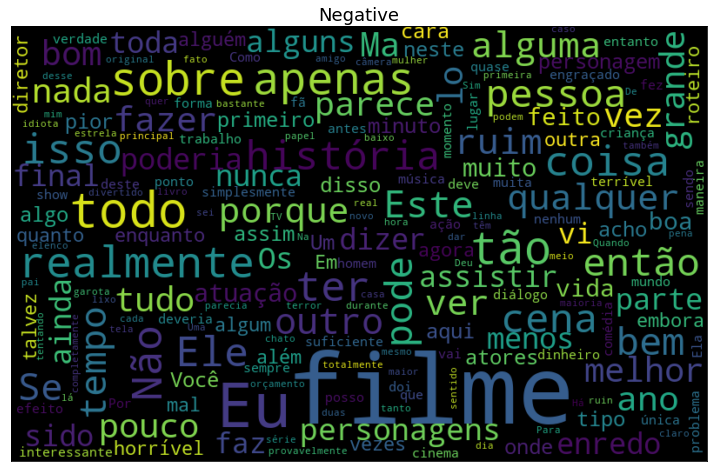

In [54]:
all_words = ' '.join([phrases for phrases in df.query("sentiment == 0").treatment_1])
word_cloud = WordCloud(width = 800, height = 500, max_font_size = 110, collocations = False).generate(all_words)

plt.figure(figsize = (16, 8))
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.title("Negative", fontsize = 18)
plt.xticks([])
plt.yticks([])

Here, we can already see some very important words, such as "menos", "ruim", "cara", "nunca", and others. Let's see a similar graph, this time for the positive sentiments:

([], <a list of 0 Text major ticklabel objects>)

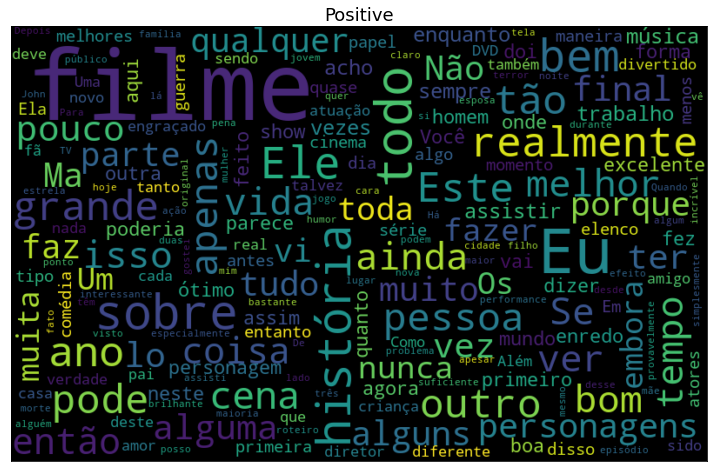

In [55]:
all_words = ' '.join([phrases for phrases in df.query("sentiment == 1").treatment_1])
word_cloud = WordCloud(width = 800, height = 500, max_font_size = 110, collocations = False).generate(all_words)

plt.figure(figsize = (16, 8))
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.title("Positive", fontsize = 18)
plt.xticks([])
plt.yticks([])

Again, some words are very interesting here, such as "melhor", "bom", "melhores", "boa", and others.

# Trying to use our classification algortihm once again

Finally, we can try to use our classification algorithm once again, and see if we improved upon our initial prediction. Thus, we can do:

In [56]:
vec   = CountVectorizer(max_features = 200)
model = LogisticRegression( )

acc = classify_text(df, 'treatment_1', 'sentiment', vec, model)

print("Accuracy: {:.2f}%".format(acc))

Accuracy: 77.81%


Nice! We actually managed to improve our model a little bit by only removing the stopwords. Also, our model had no issue converging. However, our accuracy was still very close to the previous one. Let's check our most frequent words again:

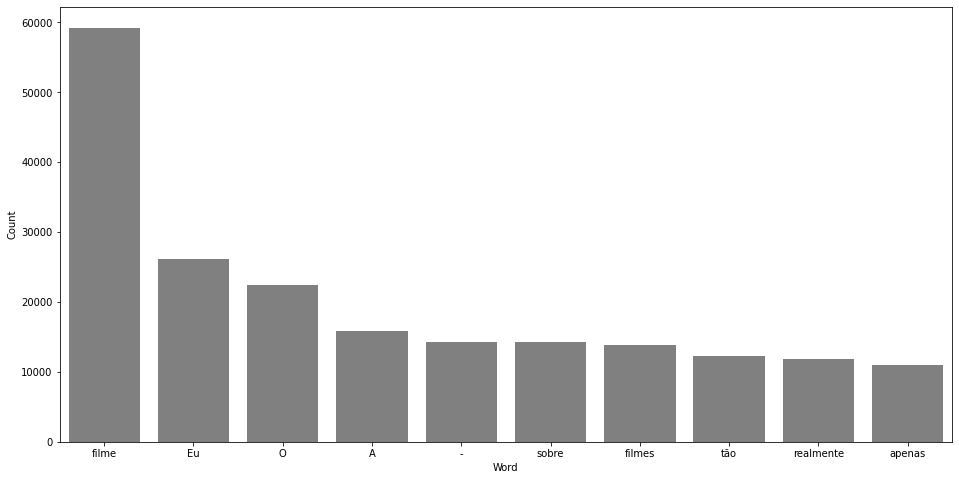

In [57]:
all_words = ' '.join([phrases for phrases in df.treatment_1])

all_tokens = token_space.tokenize(all_words)
freq = nltk.FreqDist(all_tokens)

freq_df = pd.DataFrame({"Word" : list(freq.keys( )), "Count" : list(freq.values( ))})

highest_freq_10 = freq_df.sort_values('Count', ascending = False).head(10)

plt.figure(figsize = (16, 8))
ax = sns.barplot(x = "Word", y = "Count", data = highest_freq_10, color = 'gray')

Actually, it seems that we still have some strange words in our corpus. Note that some words were not excluded simply because they were in lower case ("O", "A"). Also, it seems that we have some puntuation signs in our corpus. We should also exclude those.

# Continuing to treat our dataset

Thus, we will continue to perform some treatments to our dataset. 

## Removing punctuation marks 

Here, we will refine our stopwords by including the punctuation marks. To get all punctuation marks, we can do:

In [58]:
punctuation_list = []

for p in punctuation:
  punctuation_list.append(p)

stopwords_pt_punct = stopwords_pt + punctuation_list

punctuation_list

['!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~']

Nice! Now, we want to make a treatment to our data, and exclude the punctuation marks. Note that we will need to do a different vectorization method, so that we separate the punctuation marks from the words itself. Thus, we can use a different tokenizer:

In [59]:
token_punct = nltk.tokenize.WordPunctTokenizer( )

Now, we can redefine our function to eliminate stopwords:

In [60]:
def EliminateStopwords2(opinion):  
  new_phrase = list()
  words_text = token_punct.tokenize(opinion)
  for word in words_text:
    if word not in stopwords_pt_punct:
      new_phrase.append(word)
  
  return ' '.join(new_phrase)

Nice! Now, we can perform our second treatment:

In [61]:
df['treatment_2'] = df['text_pt'].apply(EliminateStopwords2)

In [62]:
df.head( )

,id,text_en,text_pt,sentiment,treatment_1,treatment_2
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",0,"Mais vez, Sr. Costner arrumou filme tempo nece...",Mais vez Sr Costner arrumou filme tempo necess...
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,0,Este exemplo motivo maioria filmes ação mesmos...,Este exemplo motivo maioria filmes ação mesmos...
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",0,"Primeiro tudo odeio raps imbecis, poderiam agi...",Primeiro tudo odeio raps imbecis poderiam agir...
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,0,Nem Beatles puderam escrever músicas todos gos...,Nem Beatles puderam escrever músicas todos gos...
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,0,"Filmes fotos latão palavra apropriada eles, ve...",Filmes fotos latão palavra apropriada verdade ...


Note that, this time, the second treatment has no punctuation marks. Now, let's look to the plot of our frequencies:

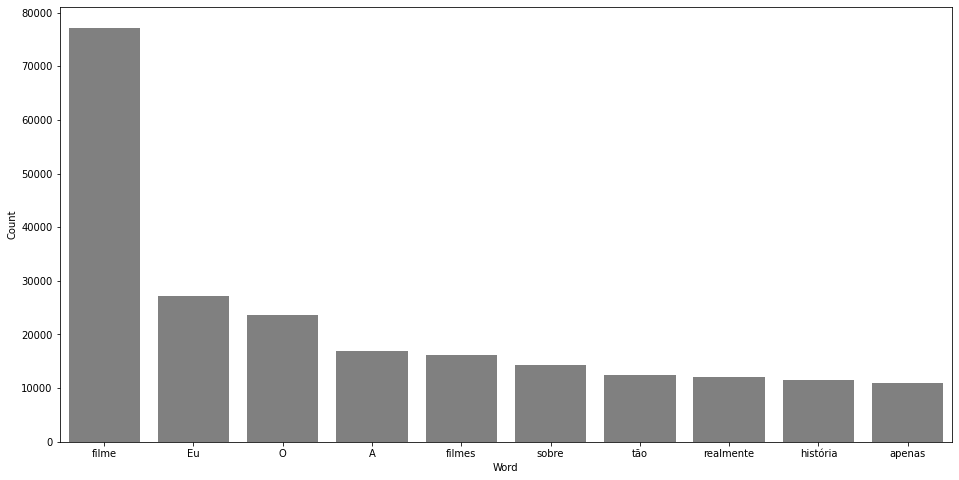

In [63]:
all_words = ' '.join([phrases for phrases in df.treatment_2])

all_tokens = token_punct.tokenize(all_words)
freq = nltk.FreqDist(all_tokens)

freq_df = pd.DataFrame({"Word" : list(freq.keys( )), "Count" : list(freq.values( ))})

highest_freq_10 = freq_df.sort_values('Count', ascending = False).head(10)

plt.figure(figsize = (16, 8))
ax = sns.barplot(x = "Word", y = "Count", data = highest_freq_10, color = 'gray')

Nice! Now, we have no punctuation marks. However, we still have some strange entries, such as "O" and "A". Also, we are still considering accents, which can make it harder to deal with portuguese text. 

## Removing accents

To remove accents, we need to use unidecode.

In [70]:
test = "Ótimo, péssimo, aéreo"

removing_accents = unidecode.unidecode(test)

removing_accents

'Otimo, pessimo, aereo'

Nice! So, we should just introduce this function to remove our accents:

In [86]:
def EliminateStopwords3(opinion, stopwords):  
  new_phrase = list()

  opinion_no_accent   = unidecode.unidecode(opinion)     # Taking the accents out

  words_text = token_punct.tokenize(opinion_no_accent)
  for word in words_text:
    if word not in stopwords:
      new_phrase.append(word)
  
  return ' '.join(new_phrase)

Note that, now, we are also passing the stopwords in our function, and we should pass the stopwords with no accent. Thus, to clean our stopwords, we can do:


In [87]:
stopwords_pt_no_acc = []

for sw in stopwords_pt_punct:
  stopwords_pt_no_acc.append(unidecode.unidecode(sw))

stopwords_pt_no_acc = list(set(stopwords_pt_no_acc))     # This removes the duplicated values
stopwords_pt_no_acc

['aquelas',
 'do',
 'muito',
 'forem',
 'minhas',
 'lhes',
 'me',
 'havemos',
 '$',
 'estivemos',
 'terei',
 'numa',
 'esteve',
 'isso',
 'voce',
 'estiver',
 'temos',
 '^',
 'eram',
 'aquele',
 'num',
 'sem',
 'tinha',
 'depois',
 'essa',
 'tive',
 "'",
 'houvermos',
 'por',
 '>',
 'houverei',
 'sejamos',
 'este',
 'tiveram',
 'tivessem',
 '@',
 'estivessemos',
 'estivesse',
 'fomos',
 'seja',
 'tivesse',
 'um',
 ':',
 '[',
 'suas',
 'tenha',
 'tivera',
 'estava',
 'minha',
 'estao',
 'foram',
 'houveriamos',
 '%',
 'sao',
 'tua',
 'em',
 'formos',
 'estivessem',
 'estiveram',
 'meu',
 '&',
 'tiverem',
 '`',
 'nosso',
 'seus',
 'tivemos',
 'tinham',
 'houveremos',
 'houvera',
 'haver',
 'pelos',
 'houver',
 'teria',
 'entre',
 'fui',
 'uma',
 'voces',
 '}',
 'teu',
 'tenham',
 'estejam',
 'vos',
 'os',
 'dela',
 '=',
 '<',
 'estar',
 'seriam',
 'hajam',
 'nem',
 'estivermos',
 'se',
 'hao',
 'houvessem',
 'ou',
 'teriamos',
 'isto',
 'tenho',
 ',',
 '"',
 '|',
 'esse',
 '-',
 'houvera

Finally, let's get our third treatment done:

In [88]:
df['treatment_3'] = df['text_pt'].apply(lambda x : EliminateStopwords3(x, stopwords_pt_no_acc))

In [89]:
df[['text_pt', 'treatment_3']].head( )

,text_pt,treatment_3
0,"Mais uma vez, o Sr. Costner arrumou um filme p...",Mais vez Sr Costner arrumou filme tempo necess...
1,Este é um exemplo do motivo pelo qual a maiori...,Este exemplo motivo maioria filmes acao mesmos...
2,"Primeiro de tudo eu odeio esses raps imbecis, ...",Primeiro tudo odeio raps imbecis poderiam agir...
3,Nem mesmo os Beatles puderam escrever músicas ...,Nem Beatles puderam escrever musicas todos gos...
4,Filmes de fotos de latão não é uma palavra apr...,Filmes fotos latao palavra apropriada verdade ...


Nice! Now, let's go to our next treatment.

## Removing uppercases

Now, to remove uppercases, we can use basic string methods:

In [90]:
test = "Paul is testing THIS!"
test.lower( )

'paul is testing this!'

Now, let's implement this in our user-defined function:

In [91]:
def EliminateStopwords4(opinion, stopwords):  
  new_phrase = list()

  opinion_no_accent   = unidecode.unidecode(opinion)     # Taking the accents out
  opinion_lower = opinion_no_accent.lower( )

  words_text = token_punct.tokenize(opinion_lower)
  for word in words_text:
    if word not in stopwords:
      new_phrase.append(word)
  
  return ' '.join(new_phrase)

Getting our fourth treatment done:

In [92]:
df['treatment_4'] = df['text_pt'].apply(lambda x : EliminateStopwords4(x, stopwords_pt_no_acc))

In [93]:
df[['text_pt', 'treatment_4']].head( )

,text_pt,treatment_4
0,"Mais uma vez, o Sr. Costner arrumou um filme p...",vez sr costner arrumou filme tempo necessario ...
1,Este é um exemplo do motivo pelo qual a maiori...,exemplo motivo maioria filmes acao mesmos gene...
2,"Primeiro de tudo eu odeio esses raps imbecis, ...",primeiro tudo odeio raps imbecis poderiam agir...
3,Nem mesmo os Beatles puderam escrever músicas ...,beatles puderam escrever musicas todos gostass...
4,Filmes de fotos de latão não é uma palavra apr...,filmes fotos latao palavra apropriada verdade ...


Now, everything is in lowercase. Also, we can see that, by making everything lowercase, we manage to remove a lot of extra stopwords! Once again, let's check our frequencies:

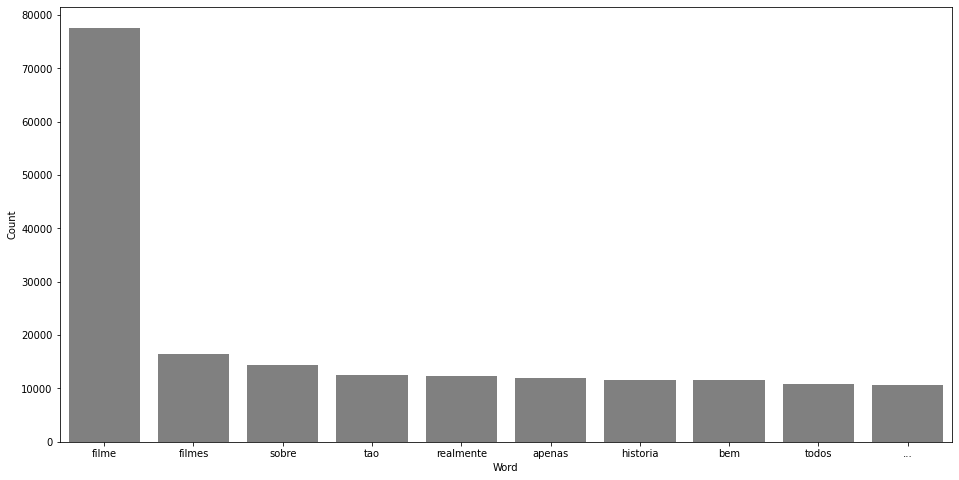

In [94]:
all_words = ' '.join([phrases for phrases in df.treatment_4])

all_tokens = token_punct.tokenize(all_words)
freq = nltk.FreqDist(all_tokens)

freq_df = pd.DataFrame({"Word" : list(freq.keys( )), "Count" : list(freq.values( ))})

highest_freq_10 = freq_df.sort_values('Count', ascending = False).head(10)

plt.figure(figsize = (16, 8))
ax = sns.barplot(x = "Word", y = "Count", data = highest_freq_10, color = 'gray')

Nice! Now, we can already see some interesting words in our top 10 most uses words, such as "bem". Still, note that the most popular words are "filme" and "filmes". Does it make sense, for us, to have both of these words have two different places? 

## Removing derivations of the words

The process of reducing different words to a single radical is called steemization. To make this, we need to use a Stemmer. This is implemented in nltk:

In [96]:
nltk.download('rslp')

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


True

In [97]:
stemmer = nltk.RSLPStemmer( )

Now, let's test our stemmer:

In [98]:
stemmer.stem("Correria")

'corr'

In [99]:
stemmer.stem("Corredor")

'corr'

In [100]:
stemmer.stem("Correr")

'corr'

Since all of these words derivate from the same radical, they say essentially the same thing (for a sentiment analysis). Note that this specific stemmer is adequate for the portuguese language. Thus, let's use the stemmer for our dataset. First, we implement the stemmer in our user-defined function:

In [101]:
def EliminateStopwords5(opinion, stopwords):  
  new_phrase = list()

  opinion_no_accent   = unidecode.unidecode(opinion)     # Taking the accents out
  opinion_lower = opinion_no_accent.lower( )

  words_text = token_punct.tokenize(opinion_lower)
  for word in words_text:
    if word not in stopwords:
      new_phrase.append(stemmer.stem(word))
  
  return ' '.join(new_phrase)

Now, let's run it:

In [103]:
df['treatment_5'] = df['text_pt'].apply(lambda x : EliminateStopwords5(x, stopwords_pt_no_acc))

In [104]:
df[['text_pt', 'treatment_5']].head( )

,text_pt,treatment_5
0,"Mais uma vez, o Sr. Costner arrumou um filme p...",vez sr costn arrum film temp necessari alem te...
1,Este é um exemplo do motivo pelo qual a maiori...,exempl motiv maior film aca mesm gener chat na...
2,"Primeiro de tudo eu odeio esses raps imbecis, ...",prim tud odei rap imbecil pod agir arm pressio...
3,Nem mesmo os Beatles puderam escrever músicas ...,beatl pud escrev music tod gost emb walt hill ...
4,Filmes de fotos de latão não é uma palavra apr...,film fot lata palavr apropri verdad tant ous q...


## Checking our final model accuracy

Finally, after performing our treatments, let's check our frequencies:

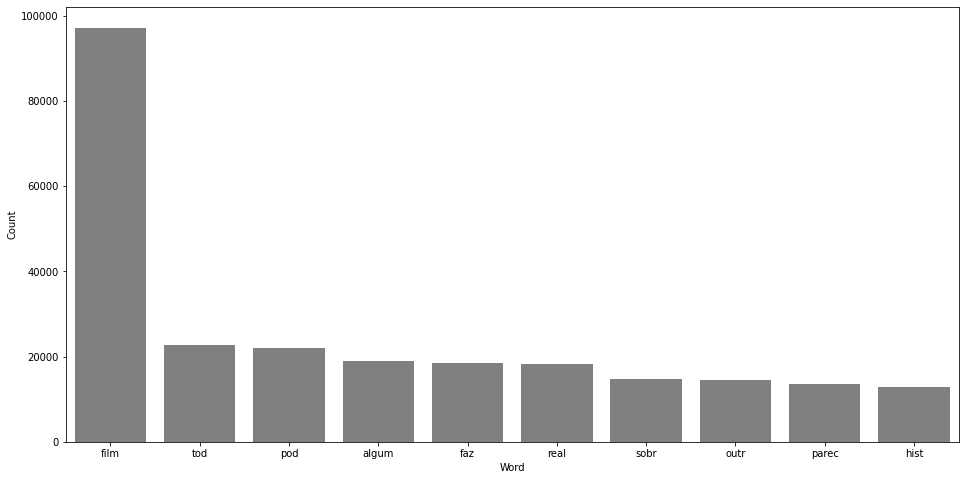

In [105]:
all_words = ' '.join([phrases for phrases in df.treatment_5])

all_tokens = token_punct.tokenize(all_words)
freq = nltk.FreqDist(all_tokens)

freq_df = pd.DataFrame({"Word" : list(freq.keys( )), "Count" : list(freq.values( ))})

highest_freq_10 = freq_df.sort_values('Count', ascending = False).head(10)

plt.figure(figsize = (16, 8))
ax = sns.barplot(x = "Word", y = "Count", data = highest_freq_10, color = 'gray')

Now, note that our words look very different, as only the most important part in each of them remained. Now, let's use a classification algorithm to perform the sentiment analysis:

In [106]:
vec   = CountVectorizer(max_features = 200)
model = LogisticRegression( )

acc = classify_text(df, 'treatment_5', 'sentiment', vec, model)

print("Accuracy: {:.2f}%".format(acc))

Accuracy: 79.73%


Nice! We managed to increase our accuracy to almost 80%!

# Extra: Other tools that we can use to improve our classification

We were able to modify our representation to improve our algorithm's performance. What more can we do to improve the accuracy of our sentiment analyzer?

First, we can try to use different vectorizers. A very popular vectorizer is the TF-IDF, which stores a numeric value to each word to allow us to understand how important the word is. For instance, the "film" radical is very common in our dataset. Thus, it should have less importance when performing our sentiment analysis. 

Thus, let's try to use it. First, let's apply it in our initial text:

In [110]:
vec   = TfidfVectorizer(max_features = 200)
model = LogisticRegression( )

acc = classify_text(df, 'text_pt', 'sentiment', vec, model)

print("Accuracy: {:.2f}%".format(acc))

Accuracy: 76.69%


We got an accuracy of 76.69%. Now, applying in our final transformed feature:

In [111]:
vec   = TfidfVectorizer(max_features = 200)
model = LogisticRegression( )

acc = classify_text(df, 'treatment_5', 'sentiment', vec, model)

print("Accuracy: {:.2f}%".format(acc))

Accuracy: 79.55%


Nice! Again, our accuracy here was higher.

## N-grams

N-grams is another interesting concept in NLP. Using N-grams, instead of getting just a bag of words, we get some combinations of words, which store some information about how the phrase is actually structured. For instance, the set "nice movie" says a lot more information than "nice" and "movie".

Let's test it with a bigram (2 words):

In [113]:
test = "I have watched a nice movie."

tokenized_test = token_punct.tokenize(test)
pairs = nltk.ngrams(tokenized_test, 2)

In [115]:
list(pairs)

[('I', 'have'),
 ('have', 'watched'),
 ('watched', 'a'),
 ('a', 'nice'),
 ('nice', 'movie'),
 ('movie', '.')]

So, the Ngrams store the pair of words instead of just the word itself. Note that, even though the number of elements in the list stays the same, each element now stores two words. Thus, we need more memory to store and use our bigrams.

To use bi-grams in our model, we can use:

In [116]:
tfidf = TfidfVectorizer(ngram_range = (1, 2))
model = LogisticRegression( )

acc = classify_text(df, 'treatment_5', 'sentiment', tfidf, model)

print("Accuracy: {:.2f}%".format(acc))

Accuracy: 88.93%


Also, let's actually try to see which are the weights for the logistic regression model for each feature. For this, let's change our classify_text function to return the model:

In [118]:
def classify_text(text, text_col, class_col, vectorizer, model, seed = 42):
  np.random.seed(seed)

  bag_of_words = vectorizer.fit_transform(text[text_col])

  X = bag_of_words
  y = text[class_col]

  X_train, X_test, y_train, y_test = train_test_split(X, y)

  model.fit(X_train, y_train)
  
  return model.score(X_test, y_test)*100, model

Now, let's fit our model again, and obtain the weights:

In [122]:
acc, logreg = classify_text(df, 'treatment_5', 'sentiment', tfidf, model)

In [124]:
weights_df = pd.DataFrame(model.coef_[0].T, index = tfidf.get_feature_names_out( ), columns = ['Weight'])

So, the 10 highest positive weights are:

In [129]:
weights_df.sort_values('Weight', ascending = False).head(10)

,Weight
otim,6.982900
excel,6.159330
perfeit,4.764762
maravilh,4.550133
incri,4.432092
divert,4.138295
agrada,3.877342
favorit,3.843283
recom,3.698022
hilari,3.650892


And the 10 highest negative weights are:

In [130]:
weights_df.sort_values('Weight', ascending = True).head(10)

,Weight
ruim,-8.251037
pi,-7.740823
horri,-6.708456
terri,-6.174353
chat,-5.510011
nad,-4.942680
parec,-4.496452
minut,-4.319403
mal,-4.311626
lix,-4.240915


These results show that our model really learned how to make sentiment analysis! The weights really represent which movies have bad and good reviews.